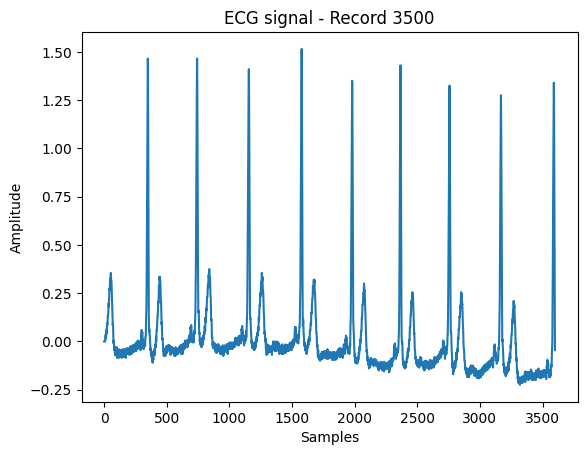

In [68]:
import wfdb
import matplotlib.pyplot as plt

record = wfdb.rdrecord('../data/raw/mit-bih-arrhythmia-database-1.0.0/202')       # read record 100 (file 100.dat + 100.hea)
annotation = wfdb.rdann('../data/raw/mit-bih-arrhythmia-database-1.0.0/202', 'atr')

# Plot ECG signal (first 10 seconds)
plt.plot(record.p_signal[:3600,0])  # Channel 0, first 10 seconds (360 Hz * 10 sec)
plt.title('ECG signal - Record 3500')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()


In [69]:
import wfdb
import numpy as np
import pandas as pd

# Load record and annotations
record = wfdb.rdrecord('../data/raw/mit-bih-arrhythmia-database-1.0.0/202')       # read record 100 (file 100.dat + 100.hea)
annotation = wfdb.rdann('../data/raw/mit-bih-arrhythmia-database-1.0.0/202', 'atr')

fs = record.fs
win_pre = int(0.2 * fs)  # 200ms before beat
win_post = int(0.4 * fs)  # 400ms after beat

beats = []
labels = []

for i, sample in enumerate(annotation.sample):
    start = sample - win_pre
    end = sample + win_post
    if start >= 0 and end <= len(record.p_signal):
        beat = record.p_signal[start:end, 0]  # first channel
        beats.append(beat)
        labels.append(annotation.symbol[i])

beats = np.array(beats)
labels = np.array(labels)

# Create DataFrame: each row = one beat, columns = amplitude points
df = pd.DataFrame(beats)
df['label'] = labels

# Save to CSV
df.to_csv('../data/processed/05/ecg_beats_record_100.csv', index=False)

print("Saved ECG beats and labels to ecg_beats_record_100.csv")


Saved ECG beats and labels to ecg_beats_record_100.csv


In [70]:
import pandas as pd

df = pd.read_csv('../data/processed/05/ecg_beats_record_100.csv')

print(df.head())
print(df['label'].value_counts())  # Check how many beats per class

print(df.shape)  # Rows = beats, Columns = 217 (216 samples + 1 label)


       0      1      2      3      4      5      6      7      8      9  ...  \
0 -0.075 -0.060 -0.055 -0.050 -0.060 -0.080 -0.085 -0.075 -0.045 -0.040  ...   
1 -0.010 -0.025 -0.035 -0.035 -0.010 -0.005  0.000 -0.005 -0.025 -0.020  ...   
2 -0.015 -0.015  0.005  0.005 -0.005 -0.005  0.015  0.005  0.030  0.000  ...   
3  0.005  0.025  0.020  0.020  0.000  0.010 -0.005  0.020  0.015 -0.010  ...   
4 -0.005  0.005 -0.020 -0.030 -0.010  0.005  0.010  0.010  0.010 -0.015  ...   

     207    208    209    210    211    212    213    214    215  label  
0 -0.005 -0.005 -0.005 -0.025 -0.020 -0.005 -0.010 -0.005 -0.025      +  
1 -0.060 -0.070 -0.040 -0.045 -0.050 -0.065 -0.075 -0.065 -0.040      N  
2 -0.010 -0.035 -0.035 -0.020 -0.015 -0.010 -0.020 -0.040 -0.045      N  
3 -0.005 -0.035 -0.045 -0.040 -0.025 -0.010 -0.035 -0.070 -0.065      N  
4 -0.080 -0.085 -0.080 -0.080 -0.085 -0.085 -0.080 -0.095 -0.080      N  

[5 rows x 217 columns]
label
N    2060
A      36
V      19
a      19
+    

In [62]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

print(dict(zip(le.classes_, le.transform(le.classes_))))
# Example output: {'N': 2, 'V': 3, 'A': 0, 'L': 1} (depends on your data)


{'+': np.int64(0), 'A': np.int64(1), 'F': np.int64(2), 'J': np.int64(3), 'N': np.int64(4), 'V': np.int64(5), 'a': np.int64(6), 'j': np.int64(7), 'x': np.int64(8), '~': np.int64(9)}


In [63]:
X = df.drop(columns=['label', 'label_enc'])
y = df['label_enc']


In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [65]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_, labels=np.unique(y_test)))


              precision    recall  f1-score   support

           +       0.67      0.67      0.67         3
           A       0.00      0.00      0.00         6
           F       0.98      0.99      0.98       335
           J       1.00      0.97      0.98        31
           N       0.96      1.00      0.98        24
           V       1.00      0.33      0.50         3
           a       1.00      1.00      1.00         6

    accuracy                           0.97       408
   macro avg       0.80      0.71      0.73       408
weighted avg       0.96      0.97      0.96       408



c:\Users\matc_\OneDrive\Desktop\final data analysis project\venv\Lib\site-packages\sklearn\metrics\_classification.py:2687: UserWarning: labels size, 7, does not match size of target_names, 10
  warnings.warn(


the precision is low because the data is imbalanced .. the normal N dominates. this hurts the rare classes

In [73]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf = GradientBoostingClassifier()  # another good option
clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # if using XGBoost

clf.fit(X_train, y_train)


c:\Users\matc_\OneDrive\Desktop\final data analysis project\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:38:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [78]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Filter out classes with fewer than 2 samples
class_counts = y.value_counts()
valid_classes = class_counts[class_counts >= 2].index
X_filtered = X[y.isin(valid_classes)]
y_filtered = y[y.isin(valid_classes)]

# First split your data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)

# Apply RandomUnderSampler on the training data only
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

print("Original training shape:", X_train.shape)
print("Resampled training shape:", X_train_res.shape)


Original training shape: (1629, 216)
Resampled training shape: (18, 216)


In [79]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_, labels=np.unique(y_test)))


              precision    recall  f1-score   support

           +       0.11      0.29      0.15         7
           A       0.00      0.00      0.00         6
           F       0.96      0.65      0.78       326
           J       0.95      1.00      0.98        40
           N       1.00      0.16      0.27        19
           V       0.03      1.00      0.05         2
           a       1.00      0.86      0.92         7
           j       0.00      0.00      0.00         1

   micro avg       0.66      0.65      0.66       408
   macro avg       0.51      0.49      0.39       408
weighted avg       0.93      0.65      0.75       408



c:\Users\matc_\OneDrive\Desktop\final data analysis project\venv\Lib\site-packages\sklearn\metrics\_classification.py:2687: UserWarning: labels size, 8, does not match size of target_names, 10
  warnings.warn(


we will be using Hyperparameter tuning

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, Flatten, BatchNormalization

model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(input_length, 1)),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(64)),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # or sigmoid for binary
])


ModuleNotFoundError: No module named 'tensorflow'